# 🚀 Artificial Intelligence - 2025 | Week 13 (Grad-CAM)
*Unlock the Future with Intelligent Machines* 🤖✨

- **Author:** Teerapong Panboonyuen (also known as Kao Panboonyuen)
- **GitHub:** [kaopanboonyuen/SC310005_ArtificialIntelligence_2025s1](https://github.com/kaopanboonyuen/SC310005_ArtificialIntelligence_2025s1)

# 🧬 Cancer Classification with Explainable AI (Grad-CAM) in PyTorch


# 📌 Step 0: Install dependencies

In [1]:
# !pip install torch torchvision torchaudio --quiet
# !pip install matplotlib seaborn scikit-learn tqdm pillow --quiet
# !pip install opencv-python --quiet
# !pip install torchsummary --quiet

# 🔗 Step 1: Import Libraries

In [2]:
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

import cv2
from tqdm import tqdm

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# 🗂 Step 2: Download and extract dataset

In [ ]:
!wget -O Cancer_IQ_OTHNCCD.zip "https://github.com/kaopanboonyuen/panboonyuen_dataset/raw/main/public_dataset/cancer/#YOUR_DATASET_FILE"
with zipfile.ZipFile("Cancer_IQ_OTHNCCD.zip", 'r') as zip_ref:
    zip_ref.extractall("./Cancer_IQ_OTHNCCD")

data_dir = "./Cancer_IQ_OTHNCCD/Cancer_IQ_OTHNCCD"
print("✅ Dataset extracted!")

--2025-10-02 06:10:41--  https://github.com/kaopanboonyuen/panboonyuen_dataset/raw/main/public_dataset/cancer/Cancer_IQ_OTHNCCD.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kaopanboonyuen/panboonyuen_dataset/main/public_dataset/cancer/Cancer_IQ_OTHNCCD.zip [following]
--2025-10-02 06:10:41--  https://raw.githubusercontent.com/kaopanboonyuen/panboonyuen_dataset/main/public_dataset/cancer/Cancer_IQ_OTHNCCD.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61402720 (59M) [application/zip]
Saving to: ‘Cancer_IQ_OTHNCCD.zip’

Cancer_IQ_OTHNCCD.z 100%[===================>]  58.56M   229MB/s  

In [4]:
# 🧹 Remove all .DS_Store files recursively
!find ./Cancer_IQ_OTHNCCD/Cancer_IQ_OTHNCCD -name ".DS_Store" -type f -delete

# ✅ Check that it's gone
!find ./Cancer_IQ_OTHNCCD/Cancer_IQ_OTHNCCD -name ".DS_Store"

# 👀 Step 3: Explore dataset

Malignant: 150 images


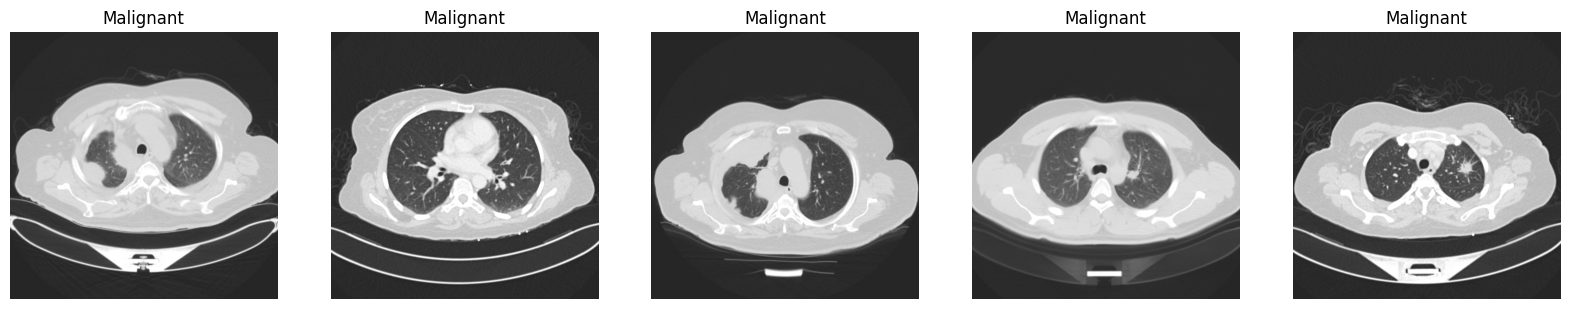

Normal: 150 images


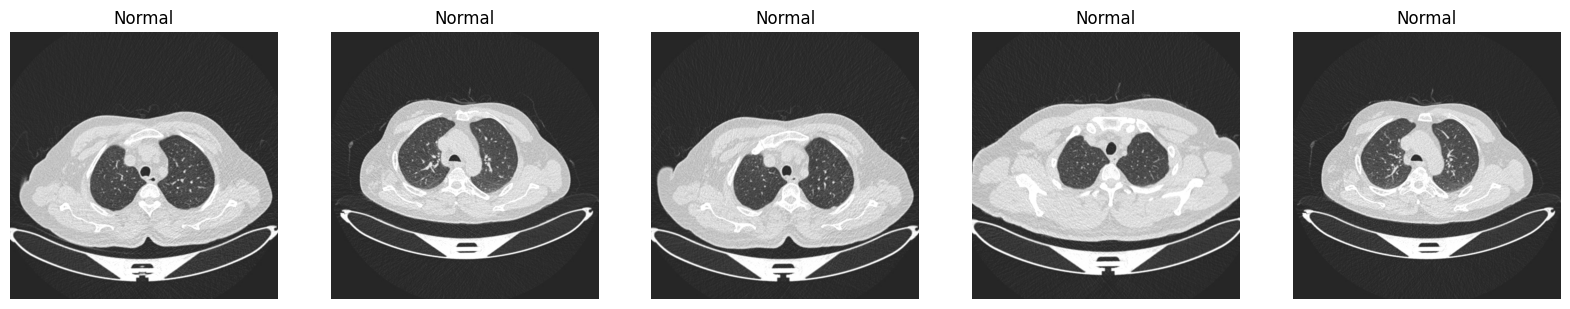

Bengin: 120 images


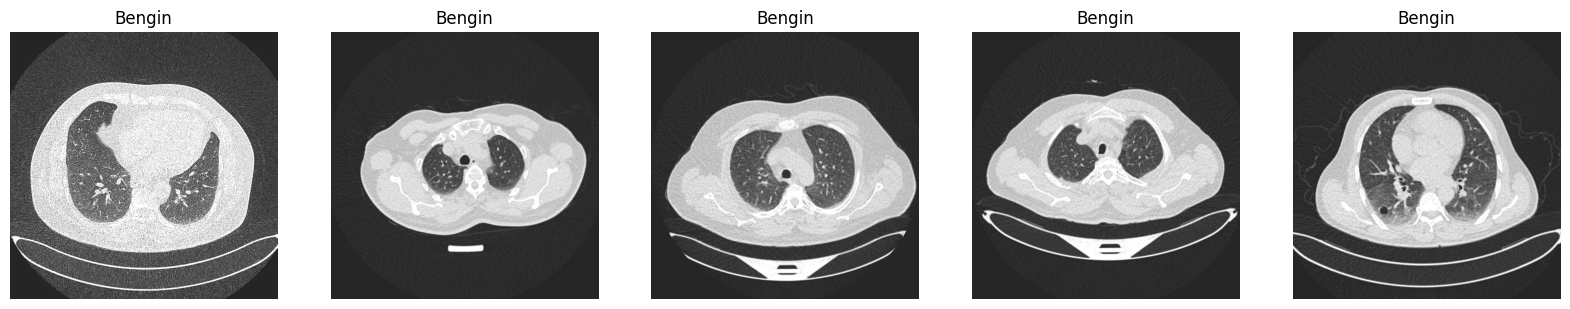

In [ ]:
import random

# 👀 Step 3: Explore dataset with 5 random samples per class
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

for cls in classes:
    images = [f for f in os.listdir(os.path.join(data_dir, cls)) if not f.startswith('.')]
    num = len(images)
    print(f"{cls}: {num} images")

    # Randomly pick 5 images
    sample_imgs = random.sample(images, min(5, len(images)))

    # Plot samples
    plt.figure(figsize=(20,4))
    for i, img_name in enumerate(sample_imgs):
        img_path = os.path.join(data_dir, cls, img_name)
        img = Image.open(img_path)
        plt.subplot(1,5,i+1)
        plt.imshow(img)
        plt.title(f"{cls}")
        plt.axis('off')
    #INSERT_YOUR_CODE_TO_DISPLAY

# 🎨 Step 4: Data Augmentation & Transforms

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# 📦 Step 5: Custom Dataset

In [7]:
# 🗑 Remove the stray text file
!rm "./Cancer_IQ_OTHNCCD/Cancer_IQ_OTHNCCD/IQ-OTH_NCCD lung cancer dataset.txt"

# ✅ Verify folder
!ls ./Cancer_IQ_OTHNCCD/Cancer_IQ_OTHNCCD

Bengin	Malignant  Normal


In [8]:
class CancerDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform
        self.classes = sorted(os.listdir(data_dir))
        for idx, cls in enumerate(self.classes):
            cls_path = os.path.join(data_dir, cls)
            for f in os.listdir(cls_path):
                self.data.append(os.path.join(cls_path, f))
                self.labels.append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Split dataset
from sklearn.model_selection import train_test_split

all_indices = list(range(len(os.listdir(data_dir))))
dataset = CancerDataset(data_dir, transform=train_transform)

# For simplicity, let's split manually
from torch.utils.data import random_split

total_len = len(dataset)
train_len = int(0.7*total_len)
val_len = int(0.15*total_len)
test_len = total_len - train_len - val_len
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len,val_len,test_len])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 🏗 Step 6: Load Pretrained ResNet50

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = #INSERT_YOUR_DEEP_LEARNING_MODEL

# Replace the last layer
num_classes = len(classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 🚀 Step 7: Training Loop

In [ ]:
epochs = #DEFINE_YOUR_EP_NUMBER

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {running_loss/len(train_loader):.4f}")

Training Epoch 1: 100%|██████████| 19/19 [00:08<00:00,  2.19it/s]


Epoch 1 loss: 0.7394


Training Epoch 2: 100%|██████████| 19/19 [00:05<00:00,  3.51it/s]


Epoch 2 loss: 0.4946


Training Epoch 3: 100%|██████████| 19/19 [00:04<00:00,  3.81it/s]


Epoch 3 loss: 0.4077


Training Epoch 4: 100%|██████████| 19/19 [00:05<00:00,  3.44it/s]


Epoch 4 loss: 0.3215


Training Epoch 5: 100%|██████████| 19/19 [00:05<00:00,  3.80it/s]

Epoch 5 loss: 0.3490


# 💾 Step 8: Save & Load Model

In [11]:
torch.save(model.state_dict(), "resnet50_cancer.pth")
# To load:
# model.load_state_dict(torch.load("resnet50_cancer.pth"))
# model.eval()

# 📊 Step 9: Evaluate

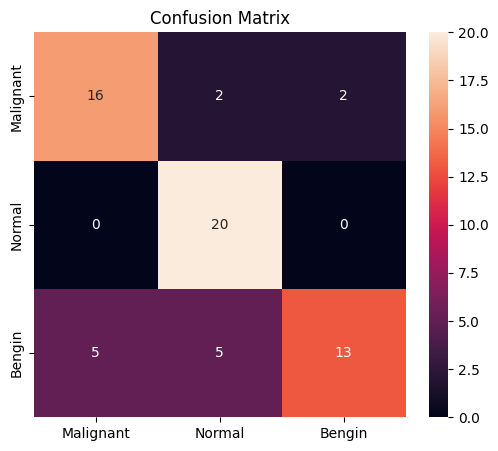

              precision    recall  f1-score   support

   Malignant     0.7619    0.8000    0.7805        20
      Normal     0.7407    1.0000    0.8511        20
      Bengin     0.8667    0.5652    0.6842        23

    accuracy                         0.7778        63
   macro avg     0.7898    0.7884    0.7719        63
weighted avg     0.7934    0.7778    0.7677        63



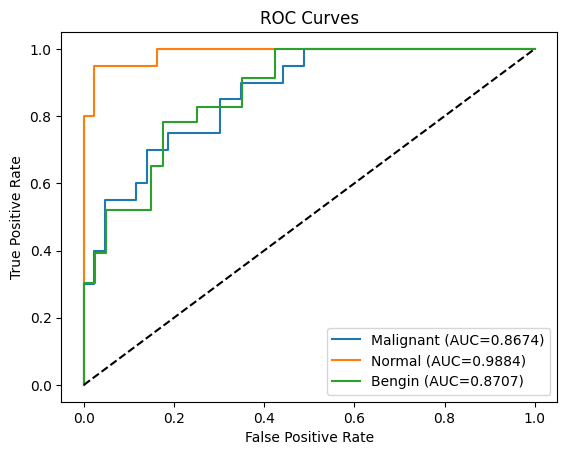

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
#INSERT_YOUR_CODE_TO_DISPLAY

# Classification Report
print(classification_report('YOUR_LABEL_VARIABLE', 'YOUR_PRED_VARIABLE', target_names=classes, digits=4))

# ROC-AUC (one-vs-rest)
y_true = np.array(all_labels)
y_score = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        y_score.append(outputs.cpu().numpy())
y_score = np.vstack(y_score)

# Compute ROC-AUC for each class
from sklearn.preprocessing import label_binarize
y_bin = label_binarize(y_true, classes=range(num_classes))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_bin[:,i], y_score[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
#INSERT_YOUR_CODE_TO_DISPLAY

# 🔍 Step 10: Grad-CAM Explainability

In [13]:
# Using hooks for Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook()

    def hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output)
        self.model.zero_grad()
        output[0, class_idx].backward()
        weights = torch.mean(self.gradients, dim=(2,3), keepdim=True)
        grad_cam_map = torch.sum(weights*self.activations, dim=1, keepdim=True)
        grad_cam_map = torch.relu(grad_cam_map)
        grad_cam_map = torch.nn.functional.interpolate(grad_cam_map, size=(224,224), mode='bilinear', align_corners=False)
        grad_cam_map = grad_cam_map.squeeze().cpu().numpy()
        grad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min() + 1e-8)
        return grad_cam_map

# Example Grad-CAM
target_layer = model.layer4[2].conv3
grad_cam = GradCAM(model, target_layer)

sample_img, sample_label = test_dataset[0]
input_tensor = sample_img.unsqueeze(0).to(device)
cam = grad_cam.generate(input_tensor, sample_label)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


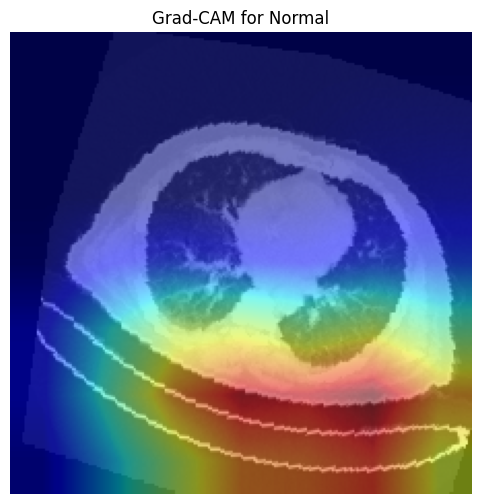

In [ ]:
# Plot Grad-CAM
plt.figure(figsize=(6,6))
img = sample_img.permute(1,2,0).numpy()
img = (img - img.min()) / (img.max()-img.min())
plt.imshow(img)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title(f"Grad-CAM for {classes[sample_label]}")
plt.axis('off')
#INSERT_YOUR_CODE_TO_DISPLAY

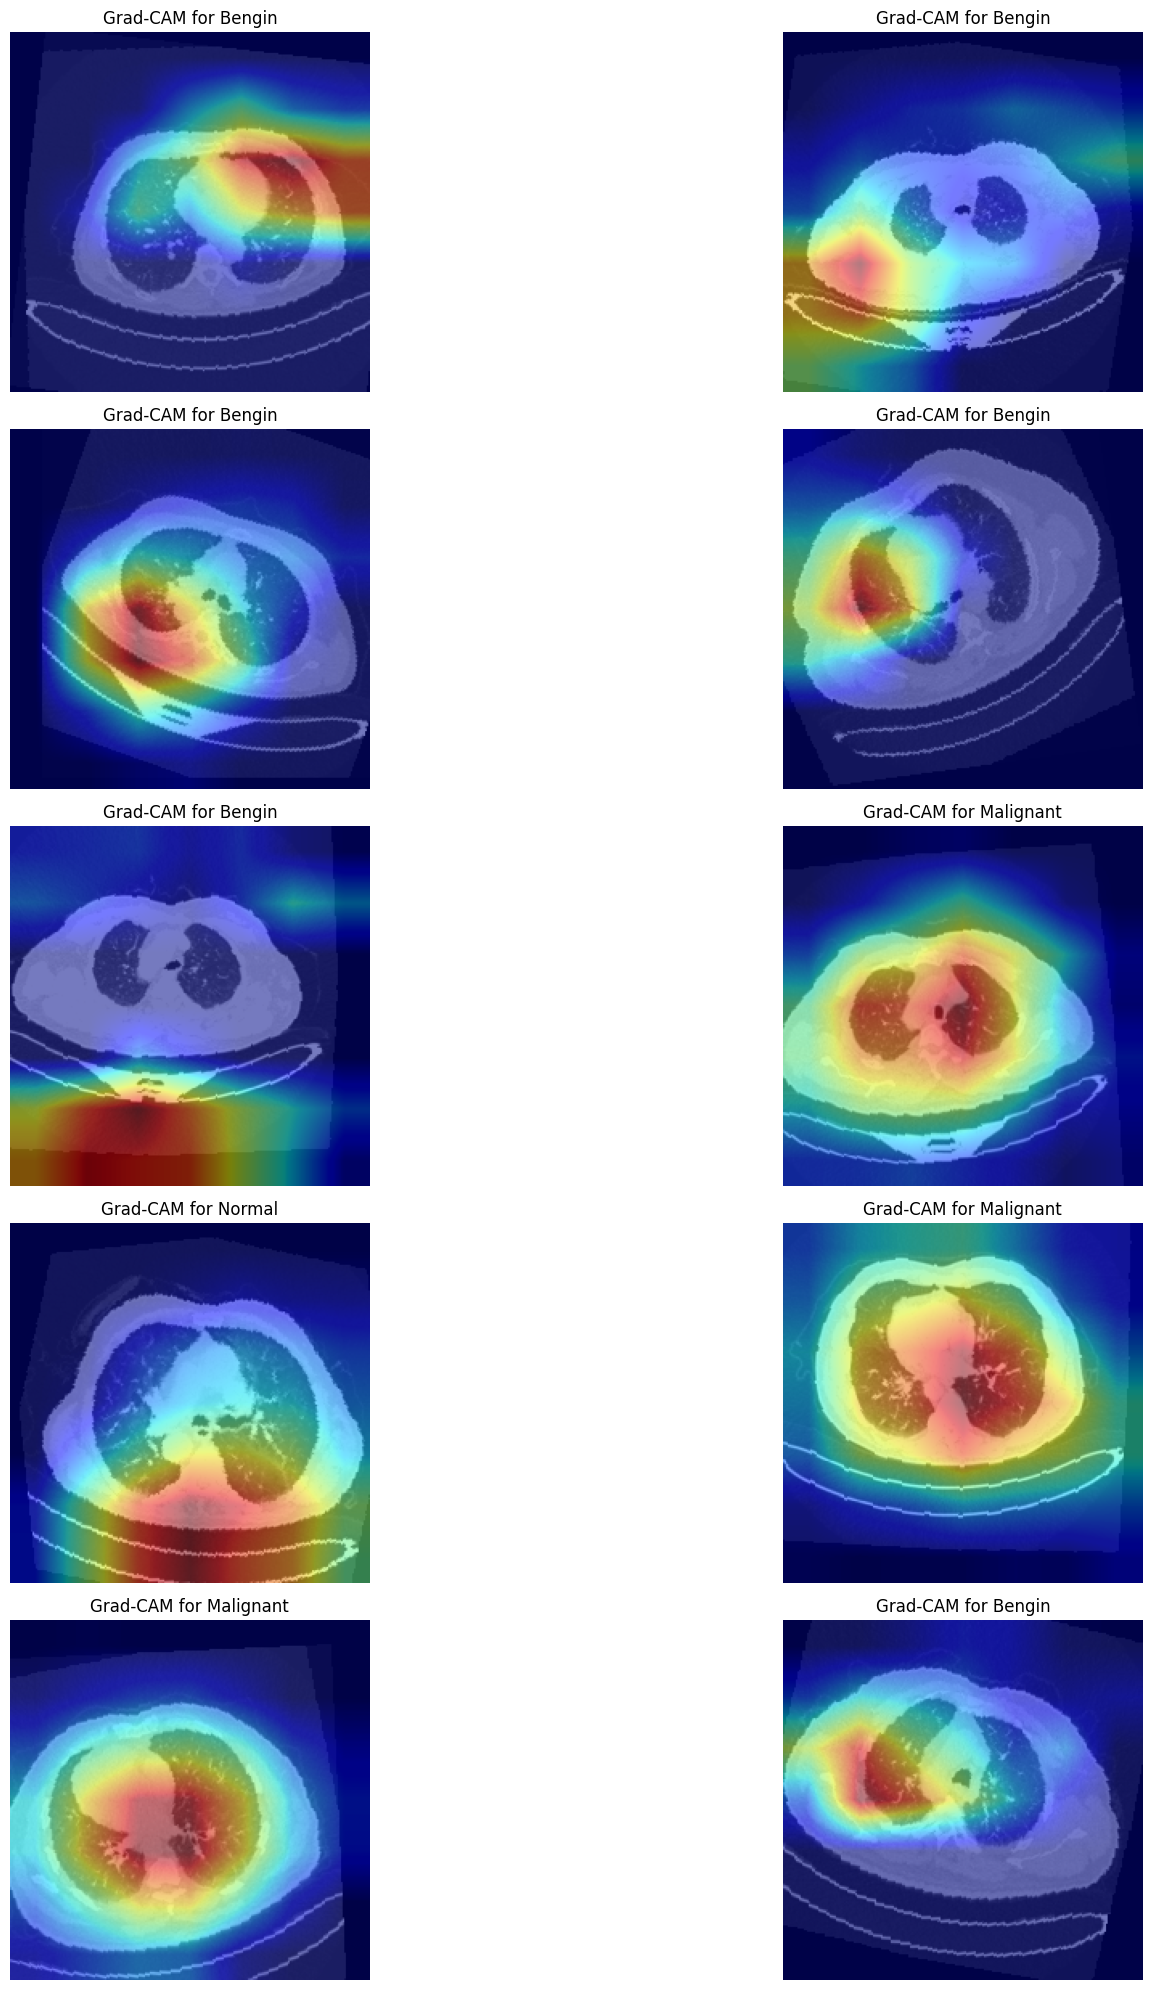

In [ ]:
import random

target_layer = model.layer4[2].conv3
grad_cam = GradCAM(model, target_layer)

num_samples = 10
indices = random.sample(range(len(test_dataset)), num_samples)

plt.figure(figsize=(20, 20))

for i, idx in enumerate(indices):
    sample_img, sample_label = test_dataset[idx]
    input_tensor = sample_img.unsqueeze(0).to(device)

    # Generate Grad-CAM
    cam = grad_cam.generate(input_tensor, sample_label)

    # Prepare image
    img_np = sample_img.permute(1,2,0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max()-img_np.min())

    # Plot
    plt.subplot(5, 2, i+1)
    plt.imshow(img_np)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM for {classes[sample_label]}")
    plt.axis('off')

plt.tight_layout()
#INSERT_YOUR_CODE_TO_DISPLAY

# 💻 Step 11: Simple Inference UI in Colab

FileUpload(value={}, accept='image/*', description='Upload')

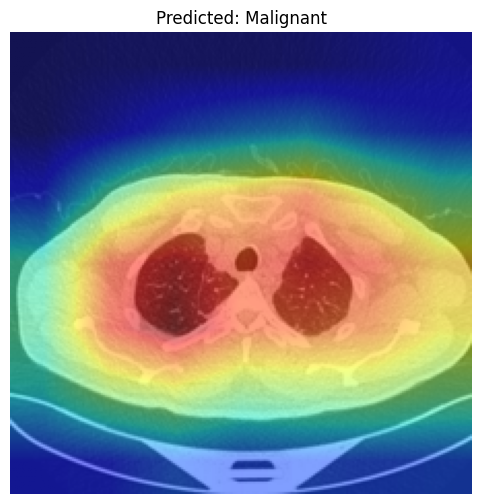

In [16]:
from IPython.display import display
import ipywidgets as widgets
from PIL import Image
import io

def infer_image(file_bytes):
    img = Image.open(io.BytesIO(file_bytes)).convert('RGB')  # wrap bytes in BytesIO
    img_t = test_transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_t)
        pred = torch.argmax(output, dim=1).item()
    cam = grad_cam.generate(img_t, pred)

    # Plot
    plt.figure(figsize=(6,6))
    img_np = np.array(img.resize((224,224)))/255.0
    plt.imshow(img_np)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f"Predicted: {classes[pred]}")
    plt.axis('off')
    plt.show()

# File upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)
display(upload_widget)

# Handle uploaded file
def on_upload_change(change):
    if upload_widget.value:
        for name, file_info in upload_widget.value.items():
            infer_image(file_info['content'])

upload_widget.observe(on_upload_change, names='value')